## ÚKOL: Deep Learning Pipeline - Klasifikace CIFRAR10
1. Rozšiřte trainloader o augmentace, vyberte dle vlastního uvážení dvě či tři, seznam [zde](https://pytorch.org/vision/stable/transforms.html). (1b)
1. Přidejte do sítě na výstup Pooling vrstev normalizaci dávek (batchnormalization - nn.BatchNorm2d) (1b)
1. Zaměňte [optimizér](https://pytorch.org/docs/stable/optim.html) z SDG na Adam. (1b)
1. Trénujte model alespoň po dobu 10 epoch (lépe 25 epoch). (1b)
1. Vyhodnoťte výsledky sítě na testovacím datasetu.
    1. Spočítejte True Positive, False Negative, False Positive (1b)
    1. Spočítejte Precision, Recall (1b)
1. Vyhodnoťte výše zmíněné metriky i pro jednotlivé třídy zvlášť. (1b)
1. Zobrazte Konfuzní matici (Confusion matrix) predikovaných tříd. (2b)
1. Okomentujte výsledky sítě. Dá se dle výsledků považovat trénování za úspěšné? Proč ano, proč ne? Rozveďte úspěšnost klasifikace jednotlivých tříd. (1b)


In [1]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Načtení datasetu CIFRAR10 za pomoci torchvision

In [3]:
# Úkol 1
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


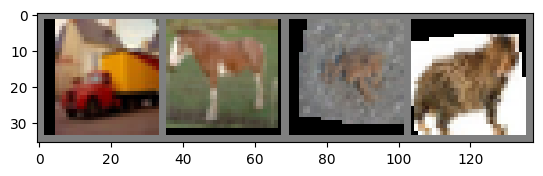

truck horse frog  cat  


In [4]:
def showbatch(img):
    '''Vratti zpet normalizaci obrazku pro neuronovou sit,
    zobrazi aktuali batch obrazku, napr. pomoci knihovny matplot lib
    a vypise odpovidajici labely.
    Parameters
    ----------
    img : tensor
          Grid obrazku v batch.
    Returns
    -------
    '''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


# trainloader vrati batch nahodnych obrazku
dataiter = iter(trainloader)
images, labels = next(dataiter)

# zobrazime obrazky i s popisky
showbatch(torchvision.utils.make_grid(images))

# Definice neuronové sítě pro klasifikaci

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 10) 

        # Úkol 2
        self.bn1 = nn.BatchNorm2d(6) # Normalizace dávky po první konvoluční vrstvě
        self.bn2 = nn.BatchNorm2d(16) # Normalizace dávky po druhé konvoluční vrstvě


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # odstraní (flatten) všechny dimenze vyjma batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# Definice loss funkce

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# Úkol 3
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Trénování sítě

In [7]:
# Úkol 4
t1=time.time()
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

t2=time.time()
print('Finished Training in {} s'.format(t2-t1))

[1,  2000] loss: 1.962
[1,  4000] loss: 1.732
[1,  6000] loss: 1.629
[1,  8000] loss: 1.598
[1, 10000] loss: 1.571
[1, 12000] loss: 1.551
[2,  2000] loss: 1.504
[2,  4000] loss: 1.490
[2,  6000] loss: 1.461
[2,  8000] loss: 1.446
[2, 10000] loss: 1.448
[2, 12000] loss: 1.435
[3,  2000] loss: 1.426
[3,  4000] loss: 1.419
[3,  6000] loss: 1.403
[3,  8000] loss: 1.413
[3, 10000] loss: 1.399
[3, 12000] loss: 1.386
[4,  2000] loss: 1.376
[4,  4000] loss: 1.369
[4,  6000] loss: 1.366
[4,  8000] loss: 1.372
[4, 10000] loss: 1.380
[4, 12000] loss: 1.362
[5,  2000] loss: 1.351
[5,  4000] loss: 1.346
[5,  6000] loss: 1.346
[5,  8000] loss: 1.338
[5, 10000] loss: 1.367
[5, 12000] loss: 1.331
[6,  2000] loss: 1.344
[6,  4000] loss: 1.328
[6,  6000] loss: 1.309
[6,  8000] loss: 1.337
[6, 10000] loss: 1.323
[6, 12000] loss: 1.307
[7,  2000] loss: 1.324
[7,  4000] loss: 1.326
[7,  6000] loss: 1.328
[7,  8000] loss: 1.291
[7, 10000] loss: 1.319
[7, 12000] loss: 1.294
[8,  2000] loss: 1.288
[8,  4000] 

In [8]:
# rychle si uložme natrénovaný model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Vyhodnocení 

In [9]:
# Úkol 5 (1 + 2)
correct = 0
total = 0
TP = 0
FP = 0
FN = 0

with torch.no_grad():
    for images, labels in testloader:
        # Predikce obrazku
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        # Spočítá počet správně predikovaných obrazku + celkový počet
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # výpočet TP, FP a FN
        TP += ((predicted == 1) & (labels == 1)).sum().item()
        FP += ((predicted == 1) & (labels == 0)).sum().item()
        FN += ((predicted == 0) & (labels == 1)).sum().item()

# Vypocet precision & recall
accuracy = 100 * correct / total
precision = TP / (TP + FP)
recall = TP / (TP + FN)

# Zobrazení výsledků
print('Accuracy of the network on the test images:', accuracy, "%")
print('True Positives:', TP)
print('False Positives:', FP)
print('False Negatives:', FN)
print('Precision:', precision)
print('Recall:', recall)

Accuracy of the network on the test images: 57.59 %
True Positives: 688
False Positives: 30
False Negatives: 73
Precision: 0.958217270194986
Recall: 0.9040735873850198


In [10]:
# Úkol 6
class_names = testset.classes

correct = 0
total = 0
TP = [0] * 10
FP = [0] * 10
FN = [0] * 10

for images, labels in testloader:
    # Predikce obrazku
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    # Spočítá počet správně predikovaných obrazku + celkový počet
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    # výpočet TP, FP a FN
    for i in range(len(labels)):
        if predicted[i] == labels[i]:
            TP[labels[i]] += 1
        else:
            FP[predicted[i]] += 1
            FN[labels[i]] += 1

# Vypocet precision & recall
accuracy = correct / total
precision = [TP[i] / (TP[i] + FP[i]) for i in range(10)]
recall = [TP[i] / (TP[i] + FN[i]) for i in range(10)]

# Zobrazení výsledků
for i in range(10):
    print("Class {}: Precision = {:.3f}, Recall = {:.3f}, TP = {:d}, FP = {:d}, FN = {:d}".format(class_names[i], precision[i], recall[i], TP[i], FP[i], FN[i]))


Class airplane: Precision = 0.598, Recall = 0.665, TP = 665, FP = 447, FN = 335
Class automobile: Precision = 0.738, Recall = 0.689, TP = 689, FP = 245, FN = 311
Class bird: Precision = 0.524, Recall = 0.454, TP = 454, FP = 413, FN = 546
Class cat: Precision = 0.361, Recall = 0.420, TP = 420, FP = 742, FN = 580
Class deer: Precision = 0.499, Recall = 0.482, TP = 482, FP = 483, FN = 518
Class dog: Precision = 0.591, Recall = 0.450, TP = 450, FP = 311, FN = 550
Class frog: Precision = 0.729, Recall = 0.571, TP = 571, FP = 212, FN = 429
Class horse: Precision = 0.512, Recall = 0.724, TP = 724, FP = 690, FN = 276
Class ship: Precision = 0.665, Recall = 0.724, TP = 724, FP = 364, FN = 276
Class truck: Precision = 0.710, Recall = 0.649, TP = 649, FP = 265, FN = 351


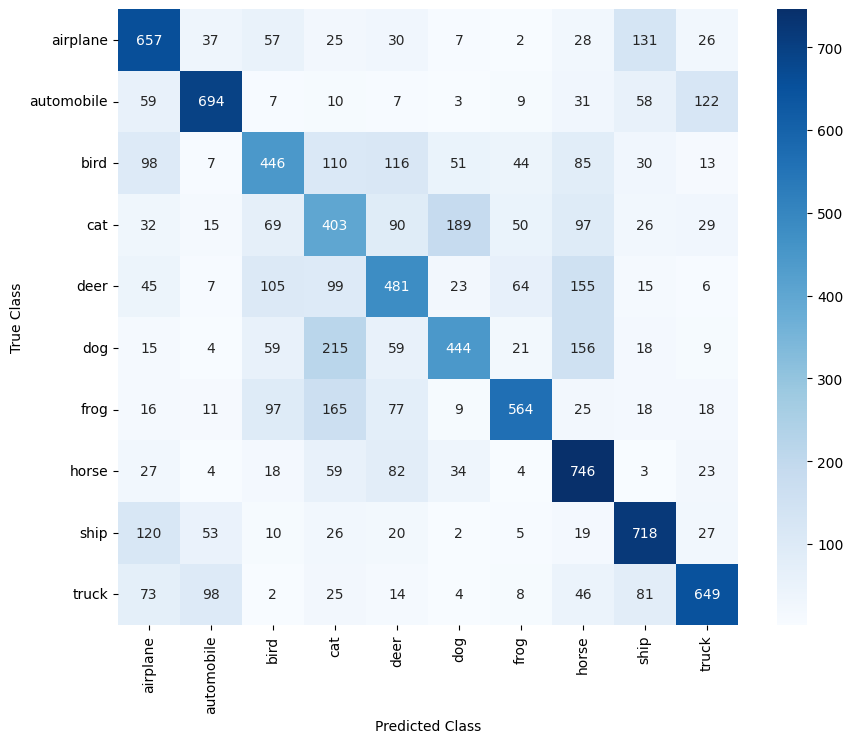

In [11]:
# Úkol 7
class_names = testset.classes

# Z testovacího datasetu získa výstupy (y_test)
y_test = []
for images, labels in testloader:
    y_test.extend(labels.numpy())
y_test = np.array(y_test)

# Spočítáme predikce pro testovací data
y_pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())

# Spočítáme konfuzní matici
cm = confusion_matrix(y_test, y_pred)

# Zobrazíme konfuzní matici pomocí knihovny Seaborn
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, fmt='d')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

 # Závěr
Podle výsledků můžeme vidět, že sítě se celkově dařilo klasifikovat obrázky s přesností okolo 57.59%. Nicméně, úspěšnost klasifikace jednotlivých tříd se liší.

Nejlepší výsledky model dosáhl pro třídy automobile, ship, truck a frog. U těchto tříd byla nejvyšší hodnota 'Recall'. Nejhůře model klasifikoval třídu bird, kde měl nejnižší přesnost (Recall = 0.454).

Celkově bychom mohli považovat trénování za relativně úspěšné, u všech klasifikovaných tříd převažuje počet True positive. Ke zlepšení přesnosti klasifikace by mělo dojít u třídy bird, dog a horse kde výsledky byli výrazně horší oproti ostatním třídám.